# Homework 07: Reinforcement Learning: Implementing a Deep Q-Network

Make sure to run every single cell in this notebook, or some libraries might be missing. Also, if you are using Colab, make sure to **change your Runtime (change runtime type under Runtime)** to a GPU, although it will work on a CPU.

In [1]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
%matplotlib inline
import os
import pdb
import sys
import copy
import json
import argparse
from datetime import datetime

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

## <span style="color:LightGreen">Implementing a DQN</span>

In this assignment you will be implementing a Deep Q-network with replay memory to play the Cartpole environment. Recall that for a DQN, we are approximating the Q-value table in Q-learning with a neural network.

The general design is a DQN neural network class that you will implemented with a DQNAgent wrapper on top. The DQNAgent controls all the weight updates and environment interactions by calling the DQN when necessary. You will also be filling in the exploration policy and you will be provided the helper class for replay memory.

## <span style="color:Orange">Problem 1</span>

In [3]:
class DQN(nn.Module):
    # YOUR CODE HERE
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    # raise NotImplementedError()

In [4]:
class QNetwork():
    # This class essentially defines the network architecture.
    # It is NOT the PyTorch Q-network model (nn.Module), but a wrapper
    # The network should take in state of the world as an input,
    # and output Q values of the actions available to the agent as the output.

    def __init__(self, args, input, output, learning_rate):
        # Define your network architecture here. It is also a good idea to define any training operations
        # and optimizers here, initialize your variables, or alternately compile your model here.
        self.weights_path = 'models/%s/%s' % (args['env'], datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

        # Network architecture.
        self.hidden = 128
        self.model = DQN(input, self.hidden, output)

        # Loss and optimizer.
        self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        if args['model_file'] is not None:
            print('Loading pretrained model from', args['model_file'])
            self.load_model_weights(args['model_file'])

    def save_model_weights(self, step):
        # Helper function to save your model / weights.
        if not os.path.exists(self.weights_path): os.makedirs(self.weights_path)
        torch.save(self.model.state_dict(), os.path.join(self.weights_path, 'model_%d.h5' % step))

    def load_model_weights(self, weight_file):
        # Helper function to load model weights.
        self.model.load_state_dict(torch.load(weight_file))

### <span style="color:Yellow">Replay Memory Helper</span>

Replay memory or Experience replay is a simple trick used to learn the Q-value network offline. It also ensures the model can learn from past experiences without weighting heavily towards current observations.

In [5]:
class Replay_Memory():
    def __init__(self, state_dim, action_dim, memory_size=50000, burn_in=10000):
        # The memory essentially stores transitions recorder from the agent
        # taking actions in the environment.

        # Burn in episodes define the number of episodes that are written into the memory from the
        # randomly initialized agent. Memory size is the maximum size after which old elements in the memory are replaced.
        # A simple (if not the most efficient) way to implement the memory is as a list of transitions.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.states = torch.zeros((self.memory_size, state_dim))
        self.next_states = torch.zeros((self.memory_size, state_dim))
        self.actions = torch.zeros((self.memory_size, 1))
        self.rewards = torch.zeros((self.memory_size, 1))
        self.dones = torch.zeros((self.memory_size, 1))
        self.ptr = 0
        self.burned_in = False
        self.not_full_yet = True

    def append(self, states, actions, rewards, next_states, dones):
        self.states[self.ptr] = states
        self.actions[self.ptr, 0] = actions
        self.rewards[self.ptr, 0] = rewards
        self.next_states[self.ptr] = next_states
        self.dones[self.ptr, 0] = dones
        self.ptr += 1

        if self.ptr > self.burn_in:
            self.burned_in = True

        if self.ptr >= self.memory_size:
            self.ptr = 0
            self.not_full_yet = False

    def sample_batch(self, batch_size=32):
        # This function returns a batch of randomly sampled transitions - i.e. state, action, reward, next state, terminal flag tuples.
        # You will feed this to your model to train.
        if self.not_full_yet:
            idxs = torch.from_numpy(np.random.choice(self.ptr, batch_size, False))
        else:
            idxs = torch.from_numpy(np.random.choice(self.memory_size, batch_size, False))

        states = self.states[idxs]
        next_states = self.next_states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        dones = self.dones[idxs]
        return states, actions, rewards, next_states, dones

## <span style="color:LightGreen">The Agent Class</span>

This section is focused on building the agent that interacts with the environment. The agent wrapper defines a policy (which you will implement), as well as all of the functionality for learning the network and using experience replay. You will implement a large chunk of this class.

## <span style="color:Orange">Problem 2</span>

In [7]:
class DQN_Agent():
    def __init__(self, args):
        # Create an instance of the network itself, as well as the memory.
        # Here is also a good place to set environmental parameters,
        # as well as training parameters - number of episodes / iterations, etc.

        # Inputs
        self.args = args
        self.environment_name = self.args['env']
        self.render = self.args['render']
        self.epsilon = args['epsilon']
        self.network_update_freq = args['network_update_freq']
        self.log_freq = args['log_freq']
        self.test_freq = args['test_freq']
        self.save_freq = args['save_freq']
        self.learning_rate = args['learning_rate']

        # Env related variables
        if self.environment_name == 'CartPole-v0':
            self.env = gym.make(self.environment_name, render_mode='rgb_array')
            self.discount_factor = 0.99
            self.num_episodes = 5000
        elif self.environment_name == 'MountainCar-v0':
            self.env = gym.make(self.environment_name, render_mode='rgb_array')
            self.discount_factor = 1.00
            self.num_episodes = 10000
        else:
            raise Exception("Unknown Environment")

        # Other Classes
        self.q_network = QNetwork(args, self.env.observation_space.shape[0], self.env.action_space.n, self.learning_rate)
        self.target_q_network = QNetwork(args, self.env.observation_space.shape[0], self.env.action_space.n, self.learning_rate)
        self.memory = Replay_Memory(self.env.observation_space.shape[0], self.env.action_space.n, memory_size=args['memory_size'])

        # Plotting
        self.rewards = []
        self.td_error = []
        self.batch = list(range(32))

        # Save hyperparameters
        self.logdir = 'logs/%s/%s' % (self.environment_name, datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
        if not os.path.exists(self.logdir):
            os.makedirs(self.logdir)
        with open(self.logdir + '/hyperparameters.json', 'w') as outfile:
            json.dump((self.args), outfile, indent=4)

    def epsilon_greedy_policy(self, q_values, epsilon):
        # Creating epsilon greedy probabilities to sample from.

        # YOUR CODE HERE
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()  # Random action
        else:
            return torch.argmax(q_values).item()  # Greedy action

        # raise NotImplementedError()

    def greedy_policy(self, q_values):

        # YOUR CODE HERE
        return torch.argmax(q_values).item()


    def train(self):
        # In this function, we will train our network.
        # If training without experience replay_memory, then you will interact with the environment
        # in this function, while also updating your network parameters.

        # When use replay memory, you should interact with environment here, and store these
        # transitions to memory, while also updating your model.
        self.burn_in_memory()
        for step in range(self.num_episodes):
            # Generate Episodes using Epsilon Greedy Policy and train the Q network.
            self.generate_episode(policy=self.epsilon_greedy_policy, mode='train',
                epsilon=self.epsilon, frameskip=self.args['frameskip'])

            # Test the network.
            if step % self.test_freq == 0:
                test_reward, test_error = self.test(episodes=20)
                self.rewards.append([test_reward, step])
                self.td_error.append([test_error, step])

            # Update the target network.
            if step % self.network_update_freq == 0:
                self.hard_update()

            # Logging.
            if step % self.log_freq == 0:
                print("Step: {0:05d}/{1:05d}".format(step, self.num_episodes))

            # Save the model.
            if step % self.save_freq == 0:
                self.q_network.save_model_weights(step)

            step += 1
            self.epsilon_decay()

            # Render and save the video with the model.
            if step % int(self.num_episodes / 3) == 0 and self.args['render']:
                # test_video(self, self.environment_name, step)
                self.q_network.save_model_weights(step)

    def td_estimate (self, state, action):
        # YOUR CODE HERE
      current_q_values = self.q_network.model(state)
      # print(f"q_value: {current_q_values}")
      td_estimate = current_q_values.gather(1, action)
      # print(f"td stimate: {td_estimate}")

      return td_estimate


    def td_target (self, reward, next_state, done):
            # YOUR CODE HERE

        with torch.no_grad():

            next_state_Q_values = self.target_q_network.model(next_state).max(1)[0]
            # print(f"qvalue : {next_state_Q_values}")
            td_target = reward.squeeze(1) + (self.discount_factor * next_state_Q_values * (1 - done).squeeze(1))
            # print(f"td_target: {td_target}")
            # print(f"reward: {reward.squeeze(1)  }")
        return td_target

    def train_dqn(self):
        if not self.memory.burned_in:
            return

        state, action, reward, next_state, done = self.memory.sample_batch(batch_size=32)

        # state = torch.tensor(state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        # reward = torch.tensor(reward, dtype=torch.float)
        # next_state = torch.tensor(next_state, dtype=torch.float)
        done = torch.tensor(done, dtype=torch.int32)

        td_est = self.td_estimate(state, action)

        td_tgt = self.td_target(reward, next_state, done)


        # print(f"TD Estimate Max: {td_est.max().item()}, Min: {td_est.min().item()}")
        # print(f"TD Target Max: {td_tgt.max().item()}, Min: {td_tgt.min().item()}")

        loss = F.smooth_l1_loss(td_est, td_tgt.detach())


        self.q_network.optim.zero_grad()
        loss.backward()
        for param in self.q_network.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.q_network.optim.step()

        return loss.item()

    def hard_update(self):
        self.target_q_network.model.load_state_dict(self.q_network.model.state_dict())

    def test(self, model_file=None, episodes=100):
        # Evaluate the performance of your agent over 100 episodes, by calculating cumulative rewards for the 100 episodes.
        # Here you need to interact with the environment, irrespective of whether you are using a memory.
        cum_reward = []
        td_error = []
        for count in range(episodes):
            reward, error = self.generate_episode(policy=self.epsilon_greedy_policy,
                mode='test', epsilon=0.05, frameskip=self.args['frameskip'])
            cum_reward.append(reward)
            td_error.append(error)
        cum_reward = torch.tensor(cum_reward)
        td_error = torch.tensor(td_error)
        print("\nTest Rewards: {0} | TD Error: {1:.4f}\n".format(torch.mean(cum_reward), torch.mean(td_error)))
        return torch.mean(cum_reward), torch.mean(td_error)

    def burn_in_memory(self):
        # Initialize your replay memory with a burn_in number of episodes / transitions.
        while not self.memory.burned_in:
            self.generate_episode(policy=self.epsilon_greedy_policy, mode='burn_in',
                epsilon=self.epsilon, frameskip=self.args['frameskip'])
        print("Burn Complete!")

    def generate_episode(self, policy, epsilon, mode='train', frameskip=1):
        """
        Collects one rollout from the policy in an environment.
        """
        done = False
        state = torch.from_numpy(self.env.reset())
        rewards = 0
        q_values = self.q_network.model.forward((state.reshape(1, -1)))
        td_error = []
        while not done:
            action = policy(q_values, epsilon)
            i = 0
            while (i < frameskip) and not done:
                next_state, reward, done, info = self.env.step(action)
                next_state = torch.from_numpy(next_state)
                rewards += reward
                i += 1
            next_q_values = self.q_network.model.forward((next_state.reshape(1, -1)))
            if mode in ['train', 'burn_in'] :
                self.memory.append(state, action, reward, next_state, done)
            else:
                td_error.append(abs(reward + self.discount_factor * (1 - done) * torch.max(next_q_values) - q_values))
            if not done:
                state = copy.deepcopy(next_state.detach())
                q_values = copy.deepcopy(next_q_values.detach())

            # Train the network.
            if mode == 'train':
                self.train_dqn()
        if td_error == []:
          return rewards, []
        return rewards, torch.mean(torch.stack(td_error))

    def plots(self):
        """
        Plots:
        1) Avg Cummulative Test Reward over 20 Plots
        2) TD Error
        """
        reward, time =  zip(*self.rewards)
        plt.figure(figsize=(8, 3))
        plt.subplot(121)
        plt.title('Cummulative Reward')
        plt.plot(time, reward)
        plt.xlabel('iterations')
        plt.ylabel('rewards')
        plt.legend()
        plt.ylim([0, None])

        loss, time =  zip(*self.td_error)
        plt.subplot(122)
        plt.title('Loss')
        plt.plot(time, loss)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

    def epsilon_decay(self, initial_eps=1.0, final_eps=0.05):
        if(self.epsilon > final_eps):
            factor = (initial_eps - final_eps) / 10000
            self.epsilon -= factor

### <span style="color:Yellow">Helpers and Hyperparameters</span>

This class contains helper functions, as well as some extra arguments that you can use to tune or play around with your DQN. There is no required parts to fill in here.

In [8]:
# Note: if you have problems creating video captures on servers without GUI,
#       you could save and relaod model to create videos on your laptop.
def test_video(agent, env_name, episodes):
    # Usage:
    #   you can pass the arguments within agent.train() as:
    #       if episode % int(self.num_episodes/3) == 0:
    #           test_video(self, self.environment_name, episode)
    save_path = "%s/video-%s" % (env_name, episodes)
    if not os.path.exists(save_path): os.makedirs(save_path)

    # To create video
    env = agent.env # gym.wrappers.Monitor(agent.env, save_path, force=True)
    reward_total = []
    state = env.reset()
    done = False
    print("Video recording the agent with epsilon {0:.4f}".format(agent.epsilon))
    while not done:
        q_values = agent.q_network.model.forward(torch.from_numpy(state.reshape(1, -1)))
        action = agent.greedy_policy(q_values)
        i = 0
        while (i < agent.args['frameskip']) and not done:
            screen = env.render(mode='rgb_array')
            plt.imshow(screen[0])
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

            next_state, reward, done, info = env.step(action)
            reward_total.append(reward)
            i += 1
        state = next_state
    print("reward_total: {}".format(torch.sum(torch.tensor(reward_total))))
    ipythondisplay.clear_output(wait=True)
    env.close()


def init_flags():

    flags = {
        "env": "CartPole-v0", # Change to "MountainCar-v0" when needed.
        "render": False,
        "train": 1,
        "frameskip" : 1,
        "network_update_freq": 10,
        "log_freq": 25,
        "test_freq": 100,
        "save_freq": 500,
        "learning_rate": 5e-4,
        "memory_size": 50000,
        "epsilon": 0.5,
        "model_file": None,
    }

    return flags

def main(render=False):
    args = init_flags()
    args["render"] = render

    # You want to create an instance of the DQN_Agent class here, and then train / test it.
    q_agent = DQN_Agent(args)

    # Render output videos using the model loaded from file.
    if args['render']: test_video(q_agent, args['env'], 1)
    else: q_agent.train()  # Train the model.

In [9]:
# For training
main()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,

Burn Complete!


<ipython-input-7-8456b8b32a73>:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.long)
<ipython-input-7-8456b8b32a73>:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  done = torch.tensor(done, dtype=torch.int32)
<ipython-input-7-8456b8b32a73>:145: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(td_est, td_tgt.detach())



Test Rewards: 9.699999809265137 | TD Error: 1.2263

Step: 00000/05000
Step: 00025/05000
Step: 00050/05000
Step: 00075/05000

Test Rewards: 9.449999809265137 | TD Error: 1.7636

Step: 00100/05000
Step: 00125/05000
Step: 00150/05000
Step: 00175/05000

Test Rewards: 9.75 | TD Error: 2.4971

Step: 00200/05000
Step: 00225/05000
Step: 00250/05000
Step: 00275/05000

Test Rewards: 9.699999809265137 | TD Error: 3.1374

Step: 00300/05000
Step: 00325/05000
Step: 00350/05000
Step: 00375/05000

Test Rewards: 9.949999809265137 | TD Error: 3.7300

Step: 00400/05000
Step: 00425/05000
Step: 00450/05000
Step: 00475/05000

Test Rewards: 22.75 | TD Error: 2.5917

Step: 00500/05000
Step: 00525/05000
Step: 00550/05000
Step: 00575/05000

Test Rewards: 18.600000381469727 | TD Error: 3.3245

Step: 00600/05000
Step: 00625/05000
Step: 00650/05000
Step: 00675/05000

Test Rewards: 9.850000381469727 | TD Error: 5.3109

Step: 00700/05000
Step: 00725/05000
Step: 00750/05000
Step: 00775/05000

Test Rewards: 9.9499998

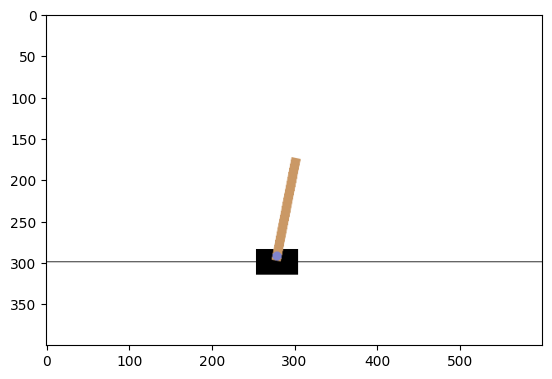

In [75]:
# For evaluating video.
main(render=True)

## <span style="color:Orange">Appendix</span>

### <span style="color:LightGreen">Resources</span>

There are many online resources for Reinforcement Learning and DQNs. Please search for them and use them as helpful background, with proper citations.


## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2024